In [2]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.models import Model, Sequential
from keras.layers import Flatten, Lambda, Dense, Conv2D, Conv2DTranspose
from keras.layers import ZeroPadding2D, Activation, Input, Concatenate, Reshape
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras import backend as K
#K.set_image_data_format('channels_first')

import cv2
import os
import numpy as np
import pandas as pd
%tensorflow_version 1.x
import tensorflow as tf
from matplotlib import pyplot

Using TensorFlow backend.


In [42]:
width, height = 512, 512
threshold = 100
emergency = False

# Load a popular model
premodel = VGG16(weights='imagenet', include_top=False, input_shape = (width, height, 3))

# Add a custom layer
flatten = Flatten()(premodel.output)

# Create the final model
model = Model(input = premodel.input, output = flatten)

# Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 512, 512, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 256, 256, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 128, 128, 128)     0   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fl...)`
  if sys.path[0] == '':


In [0]:
# Load and preprocess two images

folder_path = '/content/drive/My Drive/Masters/Colab Notebooks/Research Code/data/negative-night/frames-dark-1m/'

img_a_path = folder_path + 'frame0.jpg'
img_b_path = folder_path + 'frame1.jpg'

# Load the images
img_m = image.load_img(img_a_path, target_size=(width, height))
img_n = image.load_img(img_b_path, target_size=(width, height))

# Convert images to arrays
img_m = image.img_to_array(img_m)
img_n = image.img_to_array(img_n)

# Insert a new axis to match the model requirements
img_m = np.expand_dims(img_m, axis=0)
img_n = np.expand_dims(img_n, axis=0)

# Preprocess images
img_m = preprocess_input(img_m)
img_n = preprocess_input(img_n)

In [60]:
# View the shapes of the images
print(img_m.shape)
print(img_n.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


In [0]:
# Extract features by running the images through the model
img_a_feat = model.predict(img_m)
img_b_feat = model.predict(img_n)

In [62]:
# View the shapes of the features
print(img_a_feat.shape)
print(img_b_feat.shape)

(1, 131072)
(1, 131072)


In [63]:
feat_dist = np.linalg.norm(img_a_feat - img_b_feat)
print(feat_dist)

220.28738


In [64]:
if feat_dist < threshold:
    print("Emergency! No activity detected")
    emergency = True
else:
    print("Activity detected.")
    emergence = False

Activity detected.


In [65]:
print((img_a_feat - img_b_feat).sum())

-469.16504


# Printing feature maps in hidden layers

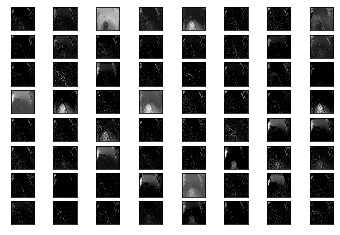

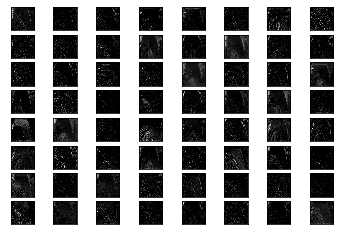

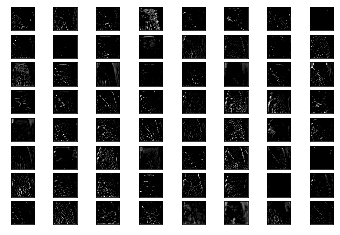

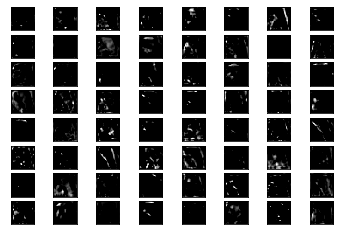

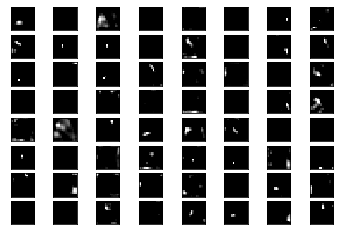

In [17]:
# load the model
model = VGG16()
# redefine model to output right after the first hidden layer
ixs = [2, 5, 9, 13, 17]
outputs = [model.layers[i].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
# load the image with the required shape
img = image.load_img(folder_path + 'frame0.jpg', target_size=(224, 224))
# convert the image to an array
img = image.img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = np.expand_dims(img, axis=0)
# prepare the image (e.g. scale pixel values for the vgg)
img = preprocess_input(img)
# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block
square = 8
for fmap in feature_maps:
	# plot all 64 maps in an 8x8 squares
	ix = 1
	for _ in range(square):
		for _ in range(square):
			# specify subplot and turn of axis
			ax = pyplot.subplot(square, square, ix)
			ax.set_xticks([])
			ax.set_yticks([])
			# plot filter channel in grayscale
			pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
			ix += 1
	# show the figure
	pyplot.show()

# Transposed convolution layer (Deconvolution)

In [0]:
width, height = 512, 512
threshold = 100
emergency = False

# Load a popular model
premodel = VGG16(weights='imagenet', include_top=False, input_shape = (3, width, height))

# Add a custom layer
flatten = Flatten()(premodel.output)

# Add the decoder layers
d = Reshape((512, 16, 16))(flatten)
d = Conv2DTranspose(256, (32, 32), strides=2, activation='relu', padding='same')(d)
d = BatchNormalization()(d)
d = Conv2DTranspose(128, (64, 64), strides=2, activation='relu', padding='same')(d)
d = BatchNormalization()(d)
#d = Conv2DTranspose(256, (64, 64), strides=2, activation='relu', padding='same')(d)
#d = BatchNormalization()(d)
#d = Conv2DTranspose(256, (128, 128), strides=2, activation='relu', padding='same')(d)
#d = BatchNormalization()(d)
#d = Conv2DTranspose(128, (256, 256), strides=2, activation='relu', padding='same')(d)
#d = BatchNormalization()(d)
d = Conv2DTranspose(64, (512, 512), strides=2, activation='relu', padding='same')(d)
decoded = Conv2D(1, (512, 512), activation='sigmoid', padding='same')(d)

# Create the encoder layers
model = Model(input = premodel.input, output = decoded)

# Compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

In [0]:
width, height = 512, 512

# define model
xmodel = Sequential()
#xmodel.add(Flatten())
xmodel.add(Reshape((512, 16, 16)))
xmodel.add(Conv2DTranspose(512, (32, 32), strides=2, activation='relu', padding='same'))
xmodel.add(BatchNormalization())
xmodel.add(Conv2DTranspose(512, (64, 64), strides=2, activation='relu', padding='same'))
xmodel.add(BatchNormalization())
xmodel.add(Conv2DTranspose(256, (64, 64), strides=2, activation='relu', padding='same'))
xmodel.add(BatchNormalization())
xmodel.add(Conv2DTranspose(256, (128, 128), strides=2, activation='relu', padding='same'))
xmodel.add(BatchNormalization())
xmodel.add(Conv2DTranspose(128, (256, 256), strides=2, activation='relu', padding='same'))
xmodel.add(BatchNormalization())
xmodel.add(Conv2DTranspose(64, (512, 512), strides=2, activation='relu', padding='same'))
xmodel.add(Conv2D(1, (512, 512), activation='sigmoid', padding='same'))

# Compile the model
xmodel.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

xmodel.build((1, 131072))

xmodel.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (1, 512, 16, 16)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (1, 512, 32, 32)          268435968 
_________________________________________________________________
batch_normalization_1 (Batch (1, 512, 32, 32)          128       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (1, 512, 64, 64)          1073742336
_________________________________________________________________
batch_normalization_2 (Batch (1, 512, 64, 64)          256       
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (1, 256, 128, 128)        536871168 
_________________________________________________________________
batch_normalization_3 (Batch (1, 256, 128, 128)     

In [0]:
img_feat_dist = img_a_feat - img_b_feat

In [0]:
temp = xmodel.predict(img_feat_dist)

NameError: ignored

In [0]:
img_feat_dist = img_a_feat - img_b_feat

In [0]:
img_feat_dist.shape

(1, 131072)

# Upsampling

In [0]:
img_feat_dist = img_a_feat - img_b_feat

In [68]:
img_feat_dist.shape

(1, 131072)

In [0]:
img_feat_dist = np.reshape(img_feat_dist, (1, 16, 16, 512))

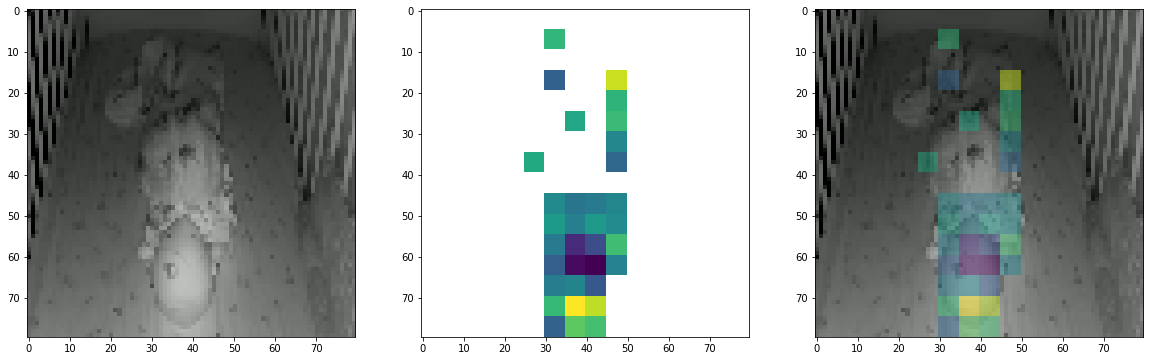

In [70]:
from keras.models import Sequential
from keras.layers import UpSampling2D, Conv2D
import numpy as np
from matplotlib import pyplot

trial = Sequential()
trial.add(UpSampling2D(size=(5,5)))

feat_up = trial.predict(img_feat_dist)

img_a_disp = image.load_img(img_a_path, target_size=(80, 80))

img_feat_dist = np.ma.masked_where(img_feat_dist == 0, img_feat_dist)
feat_up = np.ma.masked_where(feat_up == 0, feat_up)

pyplot.figure(figsize=(20,20))
pyplot.subplot(1,3,1)
pyplot.imshow(img_a_disp, 'viridis', interpolation='none')
pyplot.subplot(1,3,2)
pyplot.imshow(feat_up[0 , : , : , 0], 'viridis', interpolation='none')

pyplot.subplot(1,3,3)
pyplot.imshow(img_a_disp, interpolation='none')
pyplot.imshow(feat_up[0 , : , : , 0], 'viridis', interpolation='none', alpha=0.5)
pyplot.show()

# fig, ax = pyplot.subplots(1, 3)
# ax[0].imshow(img_feat_dist[0 , : , : , 0], interpolation='none')
# ax[1].imshow(feat_up[0 , : , : , 0], interpolation='none')
# ax[2].imshow(x_up[0 , : , : , 0])
# pyplot.show()

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
